# 1: Imports and Setup

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import KFold

num_folds = 5
epochs = 8

# 2: Download and Unzip Dataset

In [ ]:
!!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

['--2024-10-28 13:42:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  27%[====>               ]  17.85M  84.9MB/s               ',
 '        cats_and_do  74%[=============>      ]  48.60M   118MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M   128MB/s    in 0.5s    ',
 '',
 '2024-10-28 13:42:27 (128 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]',
 '']

In [ ]:
!unzip cats_and_dogs_filtered.zip

# 3: Dataset Creation Function

In [ ]:
def create_datasets(path):
    image_paths=[]
    image_labels=[]

    for dir in os.listdir(path):
        for file in os.listdir(f'{path}/{dir}'):
            image_path=f'{path}/{dir}/{file}'
            image_label=0 if dir =="cats" else 1

            image_paths.append(image_path)
            image_labels.append(image_label)


    image_paths=np.array(image_paths)
    image_labels=np.array(image_labels)

    return image_paths,image_labels


# 4: Load Training and Testing Data

In [ ]:
image_train,label_train=create_datasets('/content/cats_and_dogs_filtered/train')
image_test,label_test=create_datasets('/content/cats_and_dogs_filtered/validation')
image_train.shape,label_train.shape,image_test.shape,label_test.shape

((2000,), (2000,), (1000,), (1000,))

In [ ]:
image_train[0]

'/content/cats_and_dogs_filtered/train/cats/cat.114.jpg'

In [ ]:
label_train[0]

0

# 5: Image Preprocessing Functions

In [ ]:
def get_image_tensor_from_path(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (244, 244))
    return image, label

def augment_image(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# 6: Create TensorFlow Dataset Function

In [ ]:
def cd_dataset(x, y, batch_size=32, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if training:
        data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    data = data.shuffle(2000)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

train_dataset=cd_dataset(image_train,label_train,training=True)
test_dataset=cd_dataset(image_test,label_test)

# 7: Data Visualization

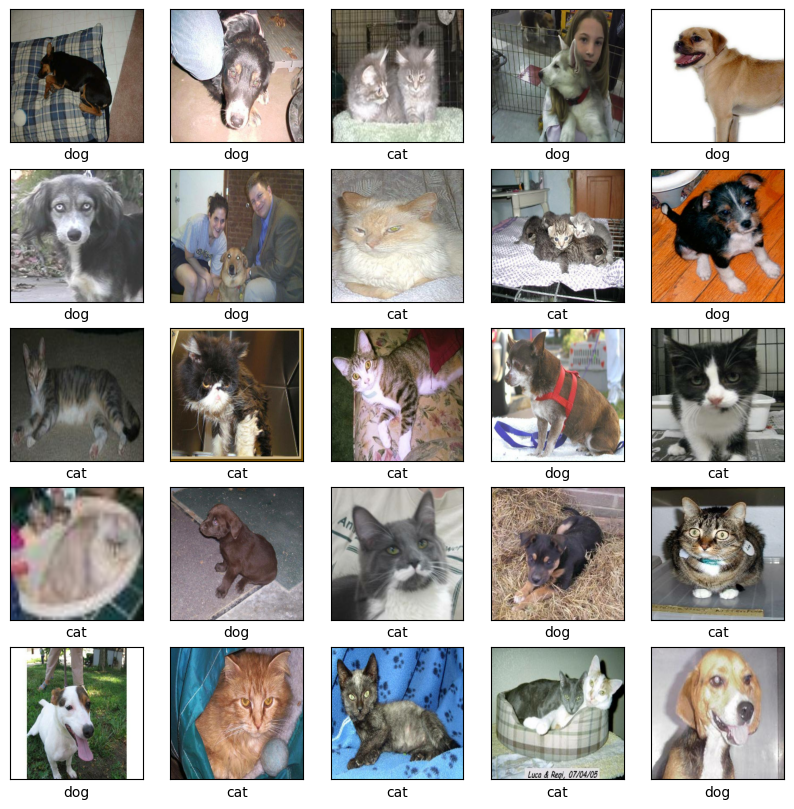

In [ ]:
class_names = ['cat', 'dog']

for x, y in test_dataset.take(1):

  plt.figure(figsize=(10, 10))

  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[i])

    plt.xticks([])
    plt.yticks([])

    plt.xlabel(class_names[y[i]])

# 8: Model Definition and Compilation

In [ ]:
b_model = VGG16(input_shape=(244, 244, 3),include_top=False,weights='imagenet')
b_model.trainable = False
b_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model=tf.keras.Sequential([
    b_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
   ]
)

model.compile('adam',loss='binary_crossentropy',metrics=['acc'])

# 9: Training with Learning Rate Scheduler

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,min_lr=1e-6)
model.fit(train_dataset,epochs=8,validation_data=test_dataset,callbacks=[lr_scheduler])

Epoch 1/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 540ms/step - acc: 0.6337 - loss: 1.5037 - val_acc: 0.8290 - val_loss: 0.3696 - learning_rate: 0.0010
Epoch 2/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - acc: 0.8296 - loss: 0.3863 - val_acc: 0.7900 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 3/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 276ms/step - acc: 0.8407 - loss: 0.3483 - val_acc: 0.8920 - val_loss: 0.2522 - learning_rate: 0.0010
Epoch 4/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - acc: 0.8611 - loss: 0.3204 - val_acc: 0.8780 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 5/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - acc: 0.8977 - loss: 0.2600 - val_acc: 0.9060 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 6/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 327ms/step - acc: 0.8999 - loss: 0.2603 - val_acc: 0.8950 - val_loss: 0.2338 - learning_rate: 0.0010
Epoch 7/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - acc: 0.8931 - loss: 0.2625 - val_acc: 0.8900 - val_loss: 0.2575 - learning_rate: 0.0010
Epoch 

# 10: Plot Training History

In [ ]:
train_history=pd.DataFrame(model.history.history)
train_history

,acc,loss,val_acc,val_loss,learning_rate
0,0.7125,0.902896,0.829,0.369568,0.001
1,0.8285,0.378921,0.790,0.395578,0.001
2,0.8630,0.325146,0.892,0.252204,0.001
3,0.8550,0.327617,0.878,0.259065,0.001
4,0.8935,0.266522,0.906,0.223935,0.001
5,0.8885,0.273206,0.895,0.233796,0.001
6,0.8895,0.259740,0.890,0.257535,0.001
7,0.8995,0.240328,0.905,0.222244,0.001


<Axes: title={'center': 'Accuracy Over Epochs'}>

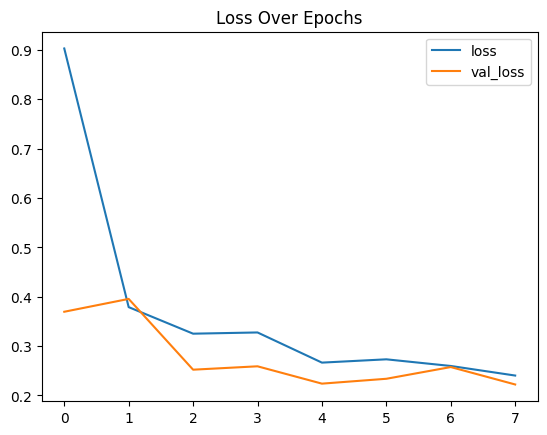

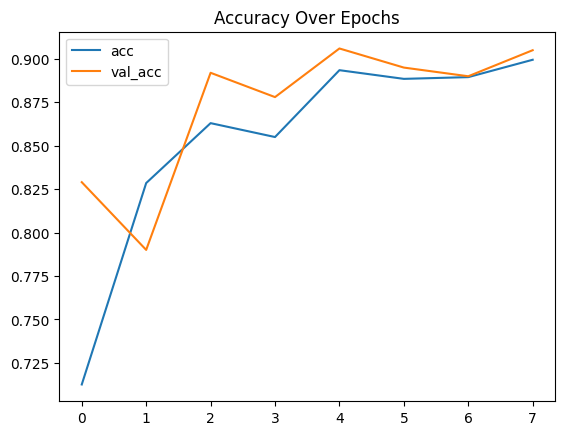

In [ ]:
train_history[['loss','val_loss']].plot(title="Loss Over Epochs")
train_history[['acc', 'val_acc']].plot(title="Accuracy Over Epochs")

# 11: Model Evaluation on Test Set

In [ ]:
test_loss,test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - acc: 0.9013 - loss: 0.2375
Test Loss: 0.22224383056163788
Test Accuracy: 0.9049999713897705


# 12: Prediction Function with Visualization

In [ ]:
def predict_and_show(start_index=None, num_samples=5,external_path=None):
    if external_path:
        image_paths = [external_path]
        actual_labels = [None]
    else:
        image_paths = image_test[start_index:start_index + num_samples]
        actual_labels = ["Dog" if label == 1 else "Cat" for label in label_test[start_index:start_index + num_samples]]

    num_samples = len(image_paths)
    num_rows = (num_samples + 4) // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for i in range(num_samples):
        image_path = image_paths[i]
        actual_label = actual_labels[i]

        image, _ = get_image_tensor_from_path(image_path, label=None)
        image_expanded = np.expand_dims(image, axis=0)

        prediction = model.predict(image_expanded)
        predicted_label = "Dog" if prediction[0] > 0.5 else "Cat"

        axes[i].imshow(image)
        title = f"Predicted: {predicted_label}"
        if actual_label is not None:
            title += f"\nActual: {actual_label}"
        title += f"\nConfidence: {prediction[0][0]:.2f}"
        axes[i].set_title(title, fontsize=10, pad=10)
        axes[i].axis("off")

    for j in range(num_samples, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


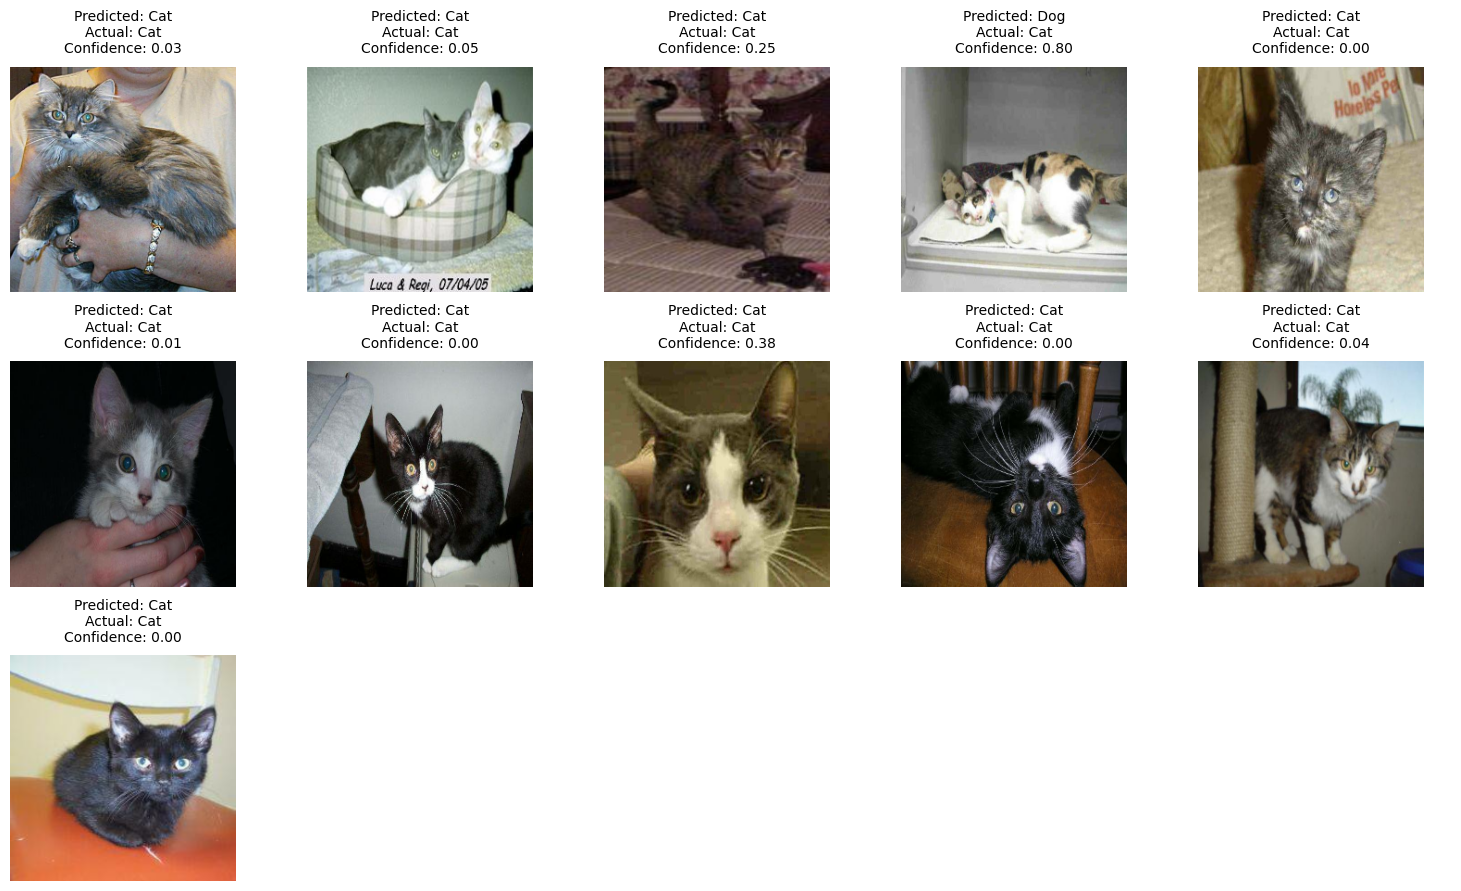

In [ ]:
predict_and_show(start_index=100,num_samples=11,external_path=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


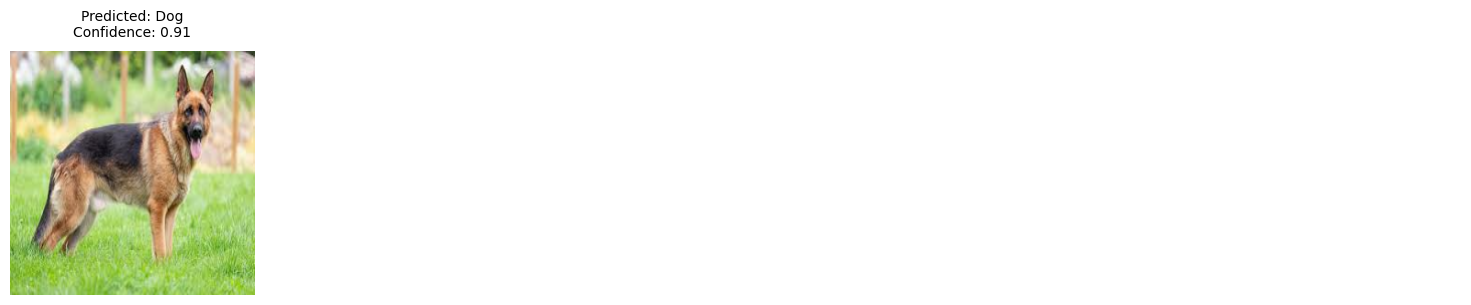

In [ ]:
predict_and_show(start_index=None,num_samples=1,external_path='/content/image1.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


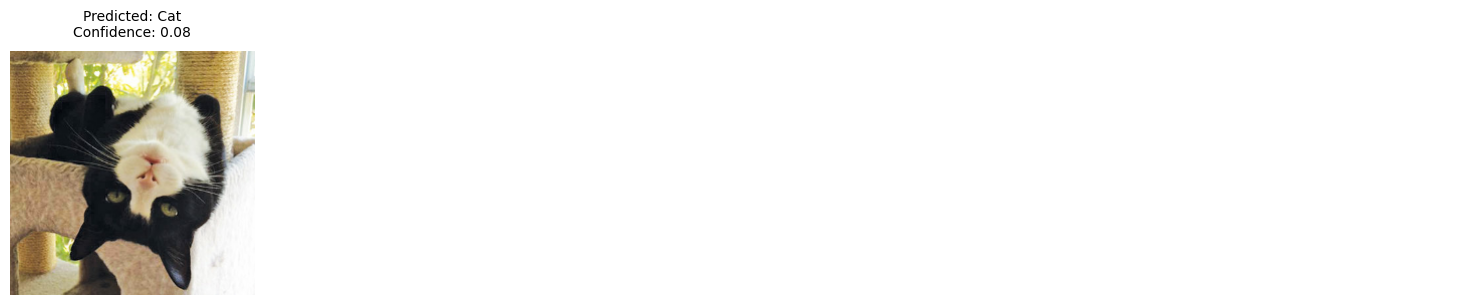

In [ ]:
predict_and_show(start_index=None,num_samples=1,external_path='/content/image2.jpg')

# 13: K-Fold Cross-Validation

In [ ]:
num_folds = 5
epochs = 8
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_nb = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(image_train):
    train_images, test_images = image_train[train_index], image_train[test_index]
    train_labels, test_labels = label_train[train_index], label_train[test_index]

    train_dataset = cd_dataset(train_images, train_labels, batch_size=32, training=True)
    test_dataset = cd_dataset(test_images, test_labels, batch_size=32)

    b_model = VGG16(input_shape=(244, 244, 3), include_top=False, weights='imagenet')
    b_model.trainable = False

    model=tf.keras.Sequential([
    b_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
   ])

    model.compile('adam',loss='binary_crossentropy', metrics=['acc'])

    print(f'Fold{fold_nb}.....')
    model.fit(train_dataset,epochs=epochs,validation_data=test_dataset,callbacks=[lr_scheduler])

    scores = model.evaluate(test_dataset)
    accuracy_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_nb += 1

print(f"Average accuracy across folds: {np.mean(accuracy_per_fold):.4f}")
print(f"Average loss across folds: {np.mean(loss_per_fold):.4f}")


Fold1.....
Epoch 1/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - acc: 0.6138 - loss: 1.6846 - val_acc: 0.7675 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 2/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - acc: 0.8158 - loss: 0.4036 - val_acc: 0.8975 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 3/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - acc: 0.8804 - loss: 0.2948 - val_acc: 0.8350 - val_loss: 0.3334 - learning_rate: 0.0010
Epoch 4/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - acc: 0.8704 - loss: 0.3400 - val_acc: 0.8950 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 5/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - acc: 0.8811 - loss: 0.2722 - val_acc: 0.9000 - val_loss: 0.2638 - learning_rate: 0.0010
Epoch 6/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - acc: 0.8780 - loss: 0.2767 - val_acc: 0.8975 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 7/8
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - acc: 0.8895 - loss: 0.2489 - val_acc: 0.9025 - val_loss: 0.2668 - learning_rate: 0.

# 14: Model Save

In [ ]:
model.save("cats_dogs_classifier.h5")
